In [1]:
# let's play with the spin isochrones from Spada & Lanzafame (2020)
# https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..76S/abstract

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

import matplotlib.pyplot as plt
from scipy import interpolate

In [50]:
df = pd.read_csv('SL20_tblA1.txt')
df.columns


Index(['Mass', 'B_V', 'T0.10', 'T0.12', 'T0.15', 'T0.20', 'T0.22', 'T0.25',
       'T0.30', 'T0.40', 'T0.50', 'T0.60', 'T0.70', 'T1.00', 'T1.50', 'T2.00',
       'T2.50', 'T4.00', 'T4.57'],
      dtype='object')

In [51]:
df.shape

(17, 19)

Text(0, 0.5, '$B - V$')

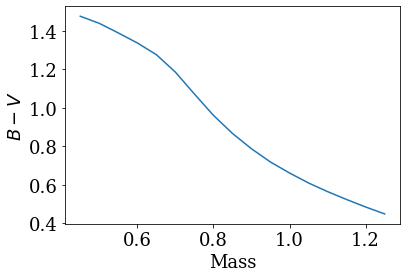

In [247]:
plt.plot(df['Mass'], df['B_V'])
plt.xlabel('Mass')
plt.ylabel('$B - V$')

Text(0, 0.5, 'P (days)')

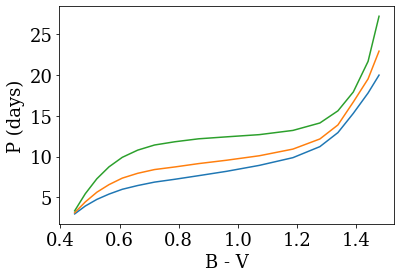

In [15]:
plt.plot(df['B_V'], df['T0.40'])
plt.plot(df['B_V'], df['T0.60'])
plt.plot(df['B_V'], df['T1.00'])
plt.xlabel('B - V')
plt.ylabel("P (days)")

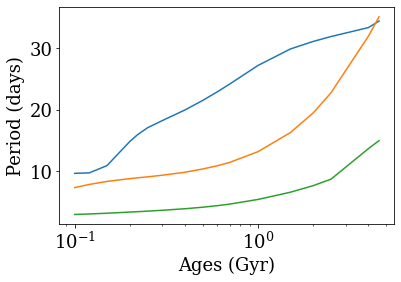

In [43]:
ages = [0.10,0.12,0.15,0.20,0.22,0.25,0.30,0.40,
        0.50,0.60,0.70,1.00,1.50,2.00,2.50,4.00,4.57]
ages = np.array(ages, dtype=np.float)

plt.plot(ages, df.iloc[0, 2:])
plt.plot(ages, df.iloc[5, 2:])
plt.plot(ages, df.iloc[15, 2:])
plt.xlabel('Ages (Gyr)')
plt.ylabel('Period (days)')
plt.xscale('log')

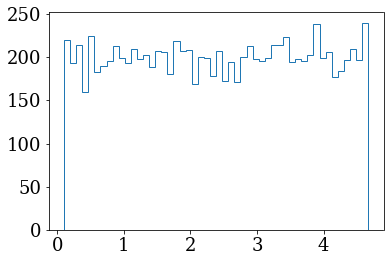

In [213]:
# If we assume ~constant star formation over the past 2 Gyr
# and a roughly uniform mass function (it's NOT, but it makes things easy...)
# -> can we make a quick forward model of what we expect to see in Kepler/K2?

nstars = 10000
age_big = np.random.random(size=nstars) * max(ages) + min(ages)
age_big = np.sort(age_big)
_ = plt.hist(age_big,histtype='step',bins=50)

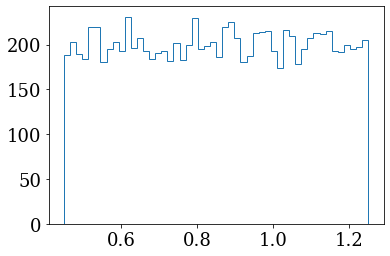

In [214]:
mass_big = np.random.random(size=nstars) * (df['Mass'].max() - df['Mass'].min()) + df['Mass'].min()
mass_big = np.sort(mass_big)
_ = plt.hist(mass_big,histtype='step',bins=50)

In [215]:
z = df.iloc[0:,2:].values
xx, yy = np.meshgrid(ages, df['Mass'].values)
f = interpolate.interp2d(xx.flatten(), yy.flatten(), z.flatten(), kind='linear')

In [216]:
xxnew, yynew = np.meshgrid(age_big, mass_big)

new_rot = f(age_big, mass_big)

In [217]:
print(new_rot.shape, age_big.shape, xxnew.shape)

(10000, 10000) (10000,) (10000, 10000)


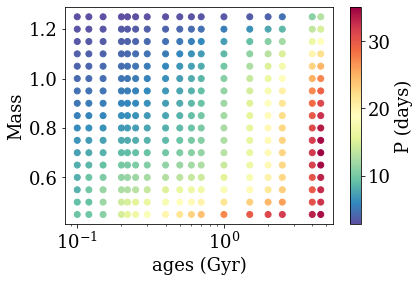

In [218]:
plt.scatter(xx.flatten(), yy.flatten(), c=z.flatten(), cmap=plt.cm.Spectral_r)
plt.xlabel('ages (Gyr)')
plt.ylabel('Mass')
plt.xscale('log')
cb = plt.colorbar()
cb.set_label('P (days)')


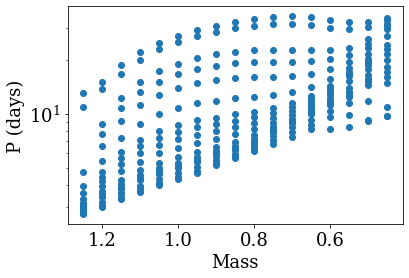

In [219]:
plt.scatter(yy, z)
plt.xlabel('Mass')
plt.ylabel('P (days)')
plt.yscale('log')
# plt.ylim(1,35)
# plt.xlim(0.52, 1.25)
plt.gca().invert_xaxis()

In [222]:
xxnew.flatten().size

100000000

In [223]:
Rind = np.random.choice(xxnew.flatten().size, nstars)

(0.52, 1.25)

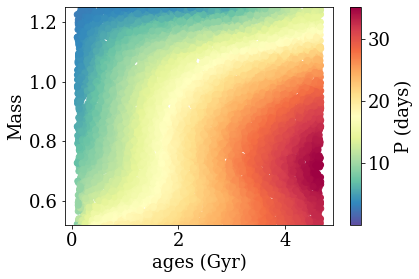

In [229]:
plt.scatter(xxnew.flatten()[Rind], yynew.flatten()[Rind], c=new_rot.flatten()[Rind], cmap=plt.cm.Spectral_r)
plt.xlabel('ages (Gyr)')
plt.ylabel('Mass')
# plt.xscale('log')
cb = plt.colorbar()
cb.set_label('P (days)')
plt.ylim(0.52, 1.25)

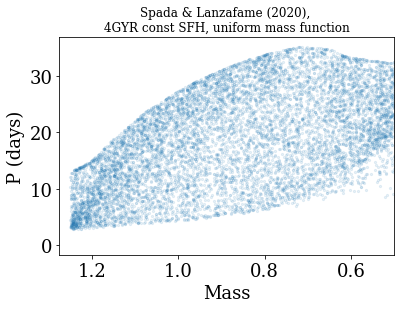

In [244]:
plt.scatter(yynew.flatten()[Rind], new_rot.flatten()[Rind], alpha=0.1, s=5)
plt.xlabel('Mass')
plt.ylabel('P (days)')
# plt.yscale('log')
# plt.ylim(3,40)
plt.xlim(0.5, 1.275)
plt.gca().invert_xaxis()
plt.title('Spada & Lanzafame (2020), \n4GYR const SFH, uniform mass function', fontsize=12)

plt.savefig('SL20_test.jpg', dpi=150, bbox_inches='tight', pad_inches=0.25)


In [309]:
def Angus2015(B_V, age):
    '''
    Compute the rotation period expected for a star of a given color (temp) and age

    NOTE: - input Age is in MYr
          - output Period is in days

    Eqn 15 from Angus+2015
    http://adsabs.harvard.edu/abs/2015MNRAS.450.1787A

    '''
    P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)

    return P

def Angus2015_age(B_V, P):
    '''
    invert the above eqn
    '''
    # P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)
    age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)
    return age

def Wright2011_tau(BV):
    '''
    http://adsabs.harvard.edu/abs/2011ApJ...743...48W
    '''
    # values from their Table 2
    BV0 = [0.46,0.61,0.76,0.92,1.13,1.32,1.41,1.50,1.55,1.61]
    BV1 = [0.61,0.75,0.92,1.12,1.31,1.41,1.49,1.55,1.60,1.95]
    logtau = [1.01, 1.08, 1.18, 1.32, 1.41, 1.49, 1.71, 1.94, 1.97, 2.12]

    clr = (np.array(BV0) + np.array(BV1)) / 2.
    
    # fit parameters I created
    ff = [0.51138488, -0.24907552, 1.00734295]
    tau = 10**np.polyval(ff, BV)
    
    return tau

def _gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function
    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian
    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

<ipython-input-309-d5aef5d95e3b>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)


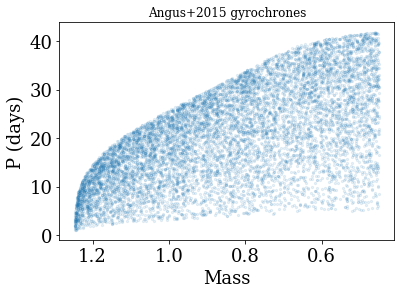

In [319]:
plt.scatter(yynew.flatten()[Rind], Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.1,s=5)

plt.xlabel('Mass')
plt.ylabel('P (days)')
plt.title('Angus+2015 gyrochrones',fontsize=12)
plt.gca().invert_xaxis()


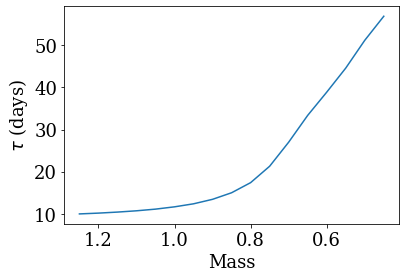

In [283]:
plt.plot(df['Mass'], Wright2011_tau(df['B_V']))
plt.xlabel('Mass')
plt.ylabel(r'$\tau$ (days)')
plt.gca().invert_xaxis()

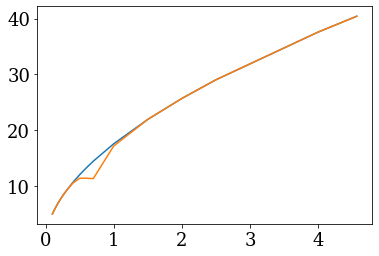

In [337]:
# plt.plot(ages, Angus2015(df['B_V'][2], ages * 1e3) /  Wright2011_tau(df['B_V'][2]))
plt.plot(ages, Angus2015(df['B_V'][2], ages * 1e3))

# for a star of a given B-V, determine:
# - when it hits the start & stop Ro numbers
# - the period at the start Ro and halfway through

BV = df['B_V'][5]
Ro1 = 0.4
Ro2 = 0.6
tau = Wright2011_tau(BV)
P1 = Ro1 * tau
P2 = Ro2 * tau
t1 = Angus2015_age(BV,P1) / 1e3
t2 = Angus2015_age(BV,P2) / 1e3

dP = _gaus(ages, (P1-P2)*.6, 0, (t1+t2)/2, (t2 - t1)/4)

plt.plot(ages, Angus2015(df['B_V'][2], ages * 1e3) + dP)


In [345]:
BVnew = np.interp(yynew.flatten()[Rind], df['Mass'].values, df['B_V'].values)

In [383]:
def stalldown(BV, age, Ro1=0.4, Ro2=0.6):
    '''
    age in Myr (per Angus eqns)
    '''
    tau = Wright2011_tau(BV)
    P1 = Ro1 * tau
    P2 = Ro2 * tau
    t1 = Angus2015_age(BV,P1)
    t2 = Angus2015_age(BV,P2)

    dP = _gaus(age, (P1-P2)*0.6, 0, (t1+t2)/2, (t2 - t1)/2)
    P = Angus2015(BV, age) + dP
    return P

def stalldown_dP(BV, age, Ro1=0.4, Ro2=0.6):
    '''
    age in Myr (per Angus eqns)
    '''
    tau = Wright2011_tau(BV)
    P1 = Ro1 * tau
    P2 = Ro2 * tau
    t1 = Angus2015_age(BV,P1)
    t2 = Angus2015_age(BV,P2)

    dP = _gaus(age, (P1-P2)*0.6, 0, (t1+t2)/2, (t2 - t1)/2)
    return dP

<ipython-input-309-d5aef5d95e3b>:21: RuntimeWarning: invalid value encountered in power
  age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)
<ipython-input-309-d5aef5d95e3b>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)


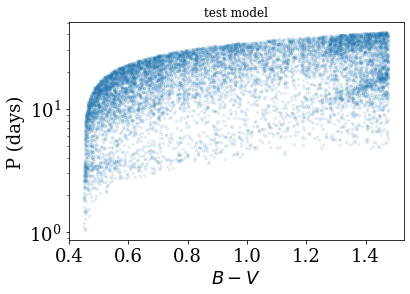

In [382]:
# plt.scatter(BVnew, Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.5,s=5)
plt.scatter(BVnew, stalldown(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.1,s=5)


plt.xlabel('$B-V$')
plt.ylabel('P (days)')
plt.title('test model',fontsize=12)
# plt.gca().invert_xaxis()
plt.yscale('log')

<ipython-input-309-d5aef5d95e3b>:21: RuntimeWarning: invalid value encountered in power
  age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)
<ipython-input-309-d5aef5d95e3b>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)


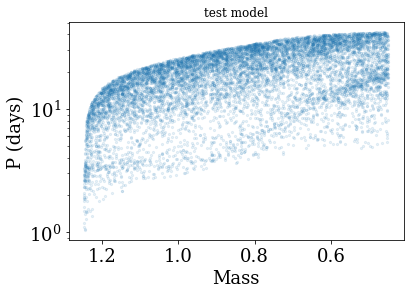

In [384]:
plt.scatter(yynew.flatten()[Rind], stalldown(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.1,s=5)

plt.xlabel('Mass')
plt.ylabel('P (days)')
plt.title('test model',fontsize=12)
plt.gca().invert_xaxis()
plt.yscale('log')

In [322]:
# gp = np.where((Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3) / Wright2011_tau(BVnew) > 0.4) & 
#               (Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3) / Wright2011_tau(BVnew) < 0.6))[0]

# plt.scatter(yynew.flatten()[Rind], Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.1,s=5)
# plt.scatter(yynew.flatten()[Rind][gp], Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3)[gp], alpha=.5,s=5)

# plt.xlabel('Mass')
# plt.ylabel('P (days)')
# plt.title('Angus+2015 gyrochrones',fontsize=12)
# plt.gca().invert_xaxis()
# # plt.yscale('log')

In [297]:
# gp = np.where((new_rot.flatten()[Rind] / Wright2011_tau(BVnew) > 0.4) & 
#               (new_rot.flatten()[Rind] / Wright2011_tau(BVnew) < 0.6))[0]

# plt.scatter(yynew.flatten()[Rind], new_rot.flatten()[Rind], alpha=0.1, s=5)
# plt.scatter(yynew.flatten()[Rind][gp], new_rot.flatten()[Rind][gp], alpha=0.5, s=5)

# plt.xlabel('Mass')
# plt.ylabel('P (days)')
# plt.gca().invert_xaxis()
# # plt.yscale('log')
# # plt.ylim(1,50)